# Part 1: 
In your project you have been working with a bias dataset. Most probabely suupervised models were underfit. You should remember that this is a real dataset, and in real life most of the time you dont have access to clean and unbias dataset. In situations like this, none of the regression models will have a good fit for the dataset due to the large predence of the 0s. In the first part of this take-home exam, you are asked to be creative, and find a solution for this problem. 

For this dataset, you can break the problem, into a two-step machine learning model. 

First step is to classify the data points as positive revenue and zero revenue. This simply is a binary classification. You should remember that when you are dealing with biased datasets, accuracy is not a reliable scoring metric. So look for a robust scoring function. 

Next, you need to build a regression model to postprocess classification results. Here is a flow chart to show you the outline of the model. 

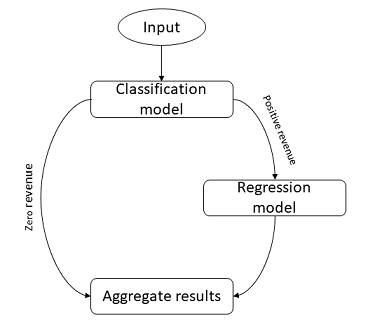

In [10]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns; sns.set()
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import json
import ast
from pandas.io.json import json_normalize
from scipy import stats
from datetime import datetime
from scipy.stats import kurtosis, skew 
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression as lm
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import cross_val_predict
from sklearn import metrics
import numpy as np
from sklearn.pipeline import make_pipeline
import warnings
from scipy.stats import mstats
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn import cluster, metrics
from sklearn.mixture import GaussianMixture 
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn.metrics import mean_squared_error
import os
import json
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.manifold import Isomap
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

In [11]:
from sklearn.metrics import precision_score

In [12]:
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

In [14]:
def convert_to_datetime(frame):
    frame['date'] = frame['date'].astype(str)
    frame['date'] = frame['date'].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    frame['date'] = pd.to_datetime(frame['date'])
    return frame

In [15]:
def read_data(csv_path='data.csv', nrows=None):

    JSON_COLUMNS = ['device', 'geoNetwork', 'trafficSource']

    df = pd.read_csv(csv_path, 
                     converters={column: ast.literal_eval for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    nan_list = ["not available in demo dataset",
            "unknown.unknown",
            "(not provided)",
            "(not set)", 
            "Not Socially Engaged"," : "
    ] 
    nan_dict = {nl:np.nan for nl in nan_list}
    
    device_list=df['device'].tolist()
    df.drop('hits',axis=1,inplace=True)
    
    df['customDimensions']=df['customDimensions'].apply(ast.literal_eval)
    df['customDimensions']=df['customDimensions'].str[0]
    df['customDimensions']=df['customDimensions'].apply(lambda x: {'index':np.NaN,'value':np.NaN} if pd.isnull(x) else x)
    
    JSON_COLUMNS = ['device', 'geoNetwork', 'trafficSource','customDimensions']

    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        df.replace(nan_dict, inplace=True) 
        
    convert_to_datetime(df)
    df.set_index('date',inplace=True)
    return df

###### Reading Dataset 

In [16]:
data=read_data()

###### Pre-processing Data

In [28]:
data.shape

(20000, 21)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2017-10-16 to 2017-11-10
Data columns (total 21 columns):
channelGrouping              20000 non-null int64
visitNumber                  20000 non-null float64
totals_bounces               20000 non-null float64
totals_newVisits             20000 non-null float64
totals_pageviews             20000 non-null float64
totals_transactionRevenue    20000 non-null float64
totals_transactions          20000 non-null float64
device.browser               20000 non-null int64
device.deviceCategory        20000 non-null int64
device.operatingSystem       20000 non-null int64
geoNetwork.city              20000 non-null int64
geoNetwork.continent         20000 non-null int64
geoNetwork.country           20000 non-null int64
geoNetwork.metro             20000 non-null int64
geoNetwork.networkDomain     20000 non-null int64
geoNetwork.region            20000 non-null int64
geoNetwork.subContinent      20000 non-null int64
trafficSourc

In [30]:
data.head()

,channelGrouping,visitNumber,totals_bounces,totals_newVisits,totals_pageviews,totals_transactionRevenue,totals_transactions,device.browser,device.deviceCategory,device.operatingSystem,...,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,trafficSource.source,customDimensions.index,customDimensions.value,classify_revenue
date,,,,,,,,,,,,,,,,,,,,,
2017-10-16,3,1.0,1.0,1.0,1.0,0.0,0.0,8,0,12,...,4,48,0,0,0,21,25,4,3,0
2017-10-16,5,6.0,0.0,0.0,2.0,0.0,0.0,5,0,3,...,2,147,27,0,18,12,70,4,4,0
2017-10-16,1,1.0,0.0,1.0,2.0,0.0,0.0,5,1,1,...,2,147,0,2435,0,12,0,4,4,0
2017-10-16,3,1.0,0.0,1.0,2.0,0.0,0.0,5,0,12,...,3,141,0,0,0,20,25,4,3,0
2017-10-16,3,1.0,0.0,1.0,2.0,0.0,0.0,5,0,12,...,2,90,0,1647,0,3,25,4,2,0


In [17]:
print('Data shape before dropping constant columns:', data.shape)

print('\nColumns being dropped:')

for col in data.columns:
    try:
        if (data[col].nunique(dropna=False) == 1):
            del(data[col])
            print(col)
    except TypeError:
        a=data[col].astype('str')
        if (a.nunique(dropna=False) == 1):
            del(data[col])
            print(col)
del(col)

print('\nData shape after dropping constant columns:', data.shape)

Data shape before dropping constant columns: (20000, 58)

Columns being dropped:
socialEngagementType
totals_visits
device.browserSize
device.browserVersion
device.flashVersion
device.language
device.mobileDeviceBranding
device.mobileDeviceInfo
device.mobileDeviceMarketingName
device.mobileDeviceModel
device.mobileInputSelector
device.operatingSystemVersion
device.screenColors
device.screenResolution
geoNetwork.cityId
geoNetwork.latitude
geoNetwork.longitude
geoNetwork.networkLocation
trafficSource.adwordsClickInfo.criteriaParameters

Data shape after dropping constant columns: (20000, 39)


In [18]:
data.fillna(0, inplace=True)

In [19]:
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect','customDimensions.value']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(data[col].values.astype('str')))
    data[col] = lbl.transform(list(data[col].values.astype('str')))

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect
customDimensions.value


In [20]:
num_cols = ["totals_hits", "totals_pageviews", "visitNumber", "visitStartTime", 'totals_bounces',  'totals_newVisits']    
for col in num_cols:
    data[col] = data[col].astype(float)

In [21]:
data.drop('totals_totalTransactionRevenue', axis=1, inplace=True)

In [22]:
data.drop('visitId', axis=1, inplace=True)

In [23]:
data.drop('visitStartTime', axis=1, inplace=True)

In [24]:
data.drop(['trafficSource.isTrueDirect','trafficSource.referralPath','totals_hits','totals_sessionQualityDim', 'totals_timeOnSite','device.isMobile','trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword','trafficSource.keyword',
       'trafficSource.medium'],axis=1, inplace=True)

## Classification

###### Adding new column to classify revenue 

In [25]:
data['classify_revenue'] = np.where(data['totals_transactionRevenue']>0, 1, 0)

In [26]:
data.head(5)

,channelGrouping,fullVisitorId,visitNumber,totals_bounces,totals_newVisits,totals_pageviews,totals_transactionRevenue,totals_transactions,device.browser,device.deviceCategory,...,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,trafficSource.source,customDimensions.index,customDimensions.value,classify_revenue
date,,,,,,,,,,,,,,,,,,,,,
2017-10-16,3,3162355547410993243,1.0,1.0,1.0,1.0,0.0,0.0,8,0,...,4,48,0,0,0,21,25,4,3,0
2017-10-16,5,8934116514970143966,6.0,0.0,0.0,2.0,0.0,0.0,5,0,...,2,147,27,0,18,12,70,4,4,0
2017-10-16,1,7992466427990357681,1.0,0.0,1.0,2.0,0.0,0.0,5,1,...,2,147,0,2435,0,12,0,4,4,0
2017-10-16,3,9075655783635761930,1.0,0.0,1.0,2.0,0.0,0.0,5,0,...,3,141,0,0,0,20,25,4,3,0
2017-10-16,3,6960673291025684308,1.0,0.0,1.0,2.0,0.0,0.0,5,0,...,2,90,0,1647,0,3,25,4,2,0


###### Creating dataset for classification model

In [27]:
y_clf=data["classify_revenue"]
X_clf=data.drop(["totals_transactionRevenue","classify_revenue"],axis=1)

In [28]:
X_clf.drop('fullVisitorId', axis=1, inplace=True)

###### Splitting data into train and test

In [29]:
X_train_org, X_test_org, y_train, y_test = train_test_split(X_clf,y_clf,test_size=.2,random_state=0)

In [87]:
X_clf.shape

(20000, 19)

In [88]:
X_clf.columns

Index(['channelGrouping', 'visitNumber', 'totals_bounces', 'totals_newVisits',
       'totals_pageviews', 'totals_transactions', 'device.browser',
       'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'trafficSource.source',
       'customDimensions.index', 'customDimensions.value'],
      dtype='object')

###### Scaling data using MinMaxScaler

In [30]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train_org)
X_test = sc.transform(X_test_org)

###### Gradient Boosting Classifier

###### Using grid search to find the optimum model parameters with best precision score and least false negetive

In [31]:
param_grid_gb = {
'n_estimators' : [20,50,80,100],
                  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb = GridSearchCV(GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=6,max_features='sqrt',subsample=0.8,random_state=10), param_grid_gb, cv=5, return_train_score=True,scoring='precision')
grid_search_gb.fit(X_train,y_train)

Parameter grid:
{'n_estimators': [20, 50, 80, 100]}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 50, 80, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='precision', verbose=0)

In [60]:
grid_search_gb.grid_scores_, grid_search_gb.best_params_, grid_search_gb.best_score_

([mean: 0.98571, std: 0.02857, params: {'n_estimators': 20},
  mean: 0.98787, std: 0.02424, params: {'n_estimators': 50},
  mean: 0.98787, std: 0.02424, params: {'n_estimators': 80},
  mean: 0.98787, std: 0.02424, params: {'n_estimators': 100}],
 {'n_estimators': 50},
 0.987875)

In [92]:
param_grid_gb = {
'max_depth' : [3,7,10,15],
'min_samples_split': [100,300,500],
                  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb2 = GridSearchCV(GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, max_features='sqrt', subsample=0.8, random_state=10), param_grid_gb, cv=5, return_train_score=True,scoring='precision')
grid_search_gb2.fit(X_train,y_train)



Parameter grid:
{'max_depth': [3, 7, 10, 15], 'min_samples_split': [100, 300, 500]}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 7, 10, 15], 'min_samples_split': [100, 300, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='precision', verbose=0)

In [93]:
grid_search_gb2.grid_scores_, grid_search_gb2.best_params_, grid_search_gb2.best_score_

([mean: 0.98787, std: 0.02424, params: {'max_depth': 3, 'min_samples_split': 100},
  mean: 0.98787, std: 0.02424, params: {'max_depth': 3, 'min_samples_split': 300},
  mean: 0.98787, std: 0.02424, params: {'max_depth': 3, 'min_samples_split': 500},
  mean: 0.98787, std: 0.02424, params: {'max_depth': 7, 'min_samples_split': 100},
  mean: 0.98143, std: 0.02445, params: {'max_depth': 7, 'min_samples_split': 300},
  mean: 0.98143, std: 0.02445, params: {'max_depth': 7, 'min_samples_split': 500},
  mean: 0.98787, std: 0.02424, params: {'max_depth': 10, 'min_samples_split': 100},
  mean: 0.98143, std: 0.02445, params: {'max_depth': 10, 'min_samples_split': 300},
  mean: 0.98143, std: 0.02445, params: {'max_depth': 10, 'min_samples_split': 500},
  mean: 0.98787, std: 0.02424, params: {'max_depth': 15, 'min_samples_split': 100},
  mean: 0.98143, std: 0.02445, params: {'max_depth': 15, 'min_samples_split': 300},
  mean: 0.98143, std: 0.02445, params: {'max_depth': 15, 'min_samples_split': 500}

In [94]:
param_grid_gb = {
'min_samples_split': [2,3,5,20,100],
'min_samples_leaf': [20,30,50]
                  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb3 = GridSearchCV(GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, max_features='sqrt', subsample=0.8,max_depth= 3, random_state=10), param_grid_gb, cv=5, return_train_score=True,scoring='precision')
grid_search_gb3.fit(X_train,y_train)


Parameter grid:
{'min_samples_split': [2, 3, 5, 20, 100], 'min_samples_leaf': [20, 30, 50]}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 5, 20, 100], 'min_samples_leaf': [20, 30, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='precision', verbose=0)

In [95]:
grid_search_gb3.grid_scores_, grid_search_gb3.best_params_, grid_search_gb3.best_score_

([mean: 0.98787, std: 0.02424, params: {'min_samples_leaf': 20, 'min_samples_split': 2},
  mean: 0.98787, std: 0.02424, params: {'min_samples_leaf': 20, 'min_samples_split': 3},
  mean: 0.98787, std: 0.02424, params: {'min_samples_leaf': 20, 'min_samples_split': 5},
  mean: 0.98787, std: 0.02424, params: {'min_samples_leaf': 20, 'min_samples_split': 20},
  mean: 0.98787, std: 0.02424, params: {'min_samples_leaf': 20, 'min_samples_split': 100},
  mean: 0.98787, std: 0.02424, params: {'min_samples_leaf': 30, 'min_samples_split': 2},
  mean: 0.98787, std: 0.02424, params: {'min_samples_leaf': 30, 'min_samples_split': 3},
  mean: 0.98787, std: 0.02424, params: {'min_samples_leaf': 30, 'min_samples_split': 5},
  mean: 0.98787, std: 0.02424, params: {'min_samples_leaf': 30, 'min_samples_split': 20},
  mean: 0.98787, std: 0.02424, params: {'min_samples_leaf': 30, 'min_samples_split': 100},
  mean: 0.98787, std: 0.02424, params: {'min_samples_leaf': 50, 'min_samples_split': 2},
  mean: 0.98787

In [96]:
param_grid_gb = {
'max_features':[5,10,15,'sqrt','log2','auto']
                  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb4 = GridSearchCV(GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, subsample=0.8,max_depth= 3,min_samples_leaf=20,min_samples_split=2, random_state=10), param_grid_gb, cv=5, return_train_score=True,scoring='precision')
grid_search_gb4.fit(X_train,y_train)


Parameter grid:
{'max_features': [5, 10, 15, 'sqrt', 'log2', 'auto']}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [5, 10, 15, 'sqrt', 'log2', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='precision', verbose=0)

In [97]:
grid_search_gb4.grid_scores_, grid_search_gb4.best_params_, grid_search_gb4.best_score_

([mean: 0.98787, std: 0.02424, params: {'max_features': 5},
  mean: 0.98787, std: 0.02424, params: {'max_features': 10},
  mean: 0.98787, std: 0.02424, params: {'max_features': 15},
  mean: 0.98787, std: 0.02424, params: {'max_features': 'sqrt'},
  mean: 0.98787, std: 0.02424, params: {'max_features': 'log2'},
  mean: 0.98787, std: 0.02424, params: {'max_features': 'auto'}],
 {'max_features': 5},
 0.987875)

In [98]:
param_grid_gb = {
'subsample':[0.6,0.7,0.8,0.9]
                  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb5 = GridSearchCV(GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, max_depth= 3,min_samples_leaf=20,min_samples_split=2, max_features=5,random_state=10), param_grid_gb, cv=5, return_train_score=True,scoring='precision')
grid_search_gb5.fit(X_train,y_train)


Parameter grid:
{'subsample': [0.6, 0.7, 0.8, 0.9]}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='precision', verbose=0)

In [99]:
grid_search_gb5.grid_scores_, grid_search_gb5.best_params_, grid_search_gb5.best_score_

([mean: 0.98787, std: 0.02424, params: {'subsample': 0.6},
  mean: 0.98787, std: 0.02424, params: {'subsample': 0.7},
  mean: 0.98787, std: 0.02424, params: {'subsample': 0.8},
  mean: 0.98787, std: 0.02424, params: {'subsample': 0.9}],
 {'subsample': 0.6},
 0.987875)

In [34]:
param_grid_gb = {
'learning_rate':[0.05,0.1,0.2]  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb6 = GridSearchCV(GradientBoostingClassifier(n_estimators=50, subsample=0.6,max_depth= 3,min_samples_leaf=20,min_samples_split=2,max_features=5, random_state=10), param_grid_gb, cv=5, return_train_score=True,scoring='precision')
grid_search_gb6.fit(X_train,y_train)
#y_test_gb = grid_search_gb.predict(X_test)

Parameter grid:
{'learning_rate': [0.05, 0.1, 0.2]}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=0.6, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='precision', verbose=0)

In [35]:
grid_search_gb6.grid_scores_, grid_search_gb6.best_params_, grid_search_gb6.best_score_

([mean: 0.98787, std: 0.02424, params: {'learning_rate': 0.05},
  mean: 0.98787, std: 0.02424, params: {'learning_rate': 0.1},
  mean: 0.47405, std: 0.43124, params: {'learning_rate': 0.2}],
 {'learning_rate': 0.05},
 0.987875)

In [36]:
gbrt = GradientBoostingClassifier( learning_rate=0.05,n_estimators=50, subsample=0.6,max_depth= 3,min_samples_leaf=20,min_samples_split=2,max_features=5, random_state=10)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=0.6, verbose=0,
              warm_start=False)

In [37]:
y_pred_gbrt_train = gbrt.predict(X_train)
y_pred_gbrt =gbrt.predict(X_test)
print('Train precision_score: %.5f'%precision_score(y_pred_gbrt_train, y_train))
print('Test precision_score: %.5f '%precision_score(y_pred_gbrt, y_test))

Train precision_score: 0.98026
Test precision_score: 1.00000 


###### Confusion Matrix

In [38]:
mat = confusion_matrix(y_test, y_pred_gbrt)
mat

array([[3958,    1],
       [   0,   41]], dtype=int64)

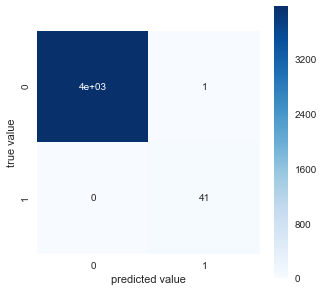

In [309]:
plt.subplots(figsize = (5,5))
sns.heatmap(mat, square=True, annot=True, cbar=True , cmap = 'Blues')
plt.xlabel('predicted value')
plt.ylabel('true value');

In [310]:
print(metrics.classification_report(y_pred_gbrt, y_test))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3958
          1       1.00      0.98      0.99        42

avg / total       1.00      1.00      1.00      4000



In [311]:
gbrt.train_score_ 
gbrt.loss_
gbrt.score(X_train, y_train)

0.9996875

###### Feature Importance

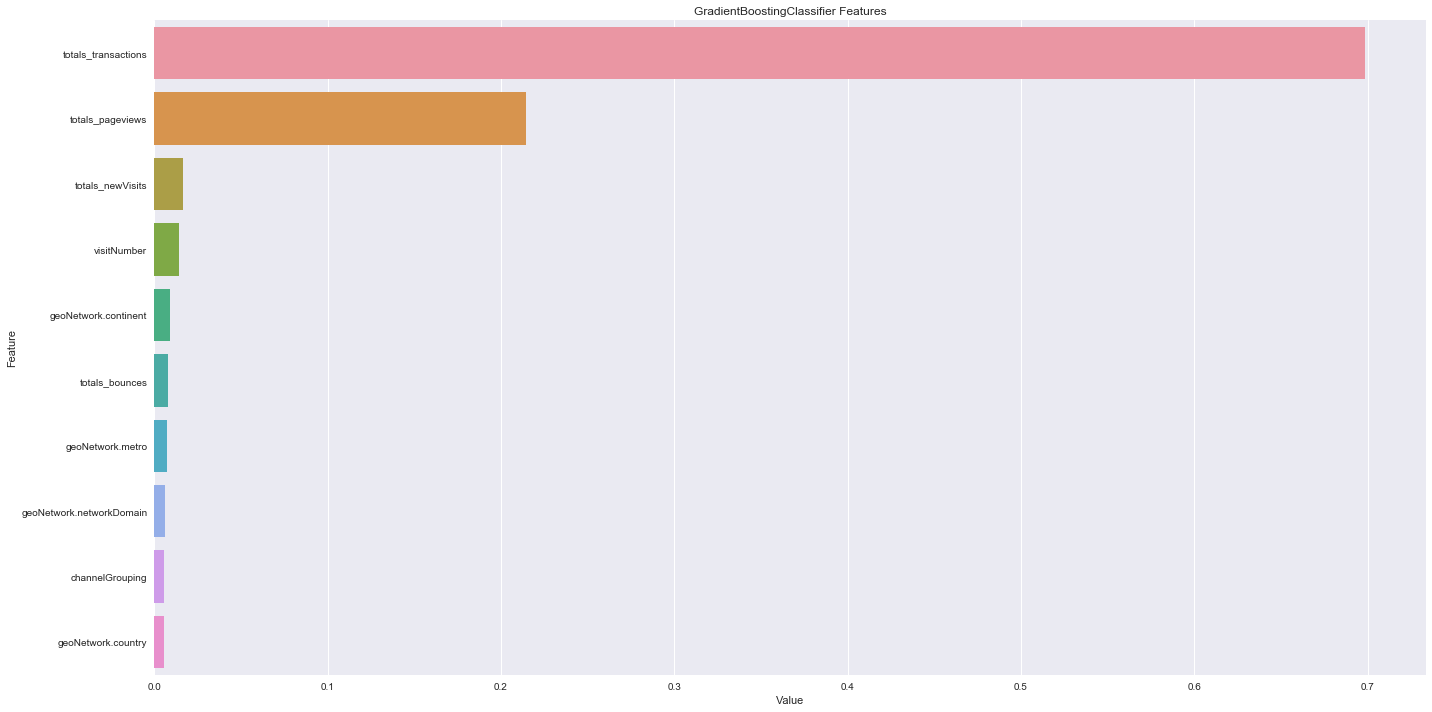

<Figure size 432x288 with 0 Axes>

In [313]:
feature_imp_gbrt = pd.DataFrame(sorted(zip(gbrt.feature_importances_,X_clf.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp_gbrt.sort_values(by="Value", ascending=False).head(10))
plt.title('GradientBoostingClassifier Features')
plt.tight_layout()
plt.show()
plt.savefig('gbrt_importances-02.png')

In [317]:
y_pred_gb = gbrt.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_pred_gb)
auc_gb = auc(fpr_gb, tpr_gb)

###### ROC Curve

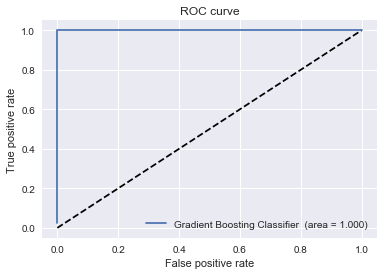

In [323]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting Classifier  (area = {:.3f})'.format(auc_gb))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###### Precision-Recall Curve

In [320]:
y_score = gbrt.decision_function(X_test)

In [321]:
precision, recall, _ = precision_recall_curve(y_test, y_score)

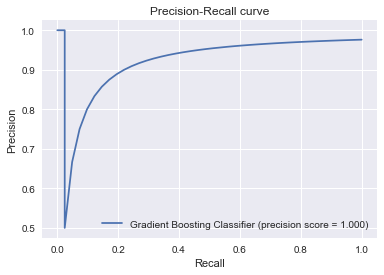

In [326]:
plt.figure(1)
plt.plot(recall, precision, label='Gradient Boosting Classifier (precision score = {:.3f})'.format(precision_score(y_pred_gbrt, y_test)))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='best')
plt.show()

## Regression

In [39]:
y_pred_full=gbrt.predict(X_clf)

In [40]:
y_pred_full.shape

(20000,)

In [41]:
data['y_pred']=y_pred_full

In [358]:
data.head()

,channelGrouping,fullVisitorId,visitNumber,totals_bounces,totals_newVisits,totals_pageviews,totals_transactionRevenue,totals_transactions,device.browser,device.deviceCategory,...,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,trafficSource.source,customDimensions.index,customDimensions.value,classify_revenue,y_pred
date,,,,,,,,,,,,,,,,,,,,,
2017-10-16,3,3162355547410993243,1.00,1.00,1.00,1.00,0.00,0.00,8,0,...,48,0,0,0,21,25,4,3,0,0
2017-10-16,5,8934116514970143966,6.00,0.00,0.00,2.00,0.00,0.00,5,0,...,147,27,0,18,12,70,4,4,0,0
2017-10-16,1,7992466427990357681,1.00,0.00,1.00,2.00,0.00,0.00,5,1,...,147,0,2435,0,12,0,4,4,0,0
2017-10-16,3,9075655783635761930,1.00,0.00,1.00,2.00,0.00,0.00,5,0,...,141,0,0,0,20,25,4,3,0,0
2017-10-16,3,6960673291025684308,1.00,0.00,1.00,2.00,0.00,0.00,5,0,...,90,0,1647,0,3,25,4,2,0,0


In [42]:
reg_data=data[data['y_pred']==1]

In [43]:
reg_data.head()

,channelGrouping,fullVisitorId,visitNumber,totals_bounces,totals_newVisits,totals_pageviews,totals_transactionRevenue,totals_transactions,device.browser,device.deviceCategory,...,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,trafficSource.source,customDimensions.index,customDimensions.value,classify_revenue,y_pred
date,,,,,,,,,,,,,,,,,,,,,
2017-10-16,3,9549826748224805897,4.0,0.0,0.0,9.0,15190000.0,1.0,5,0,...,147,19,0,76,12,25,4,4,1,1
2017-10-16,5,3700714855829972615,11.0,0.0,0.0,12.0,8000000.0,1.0,5,0,...,147,16,0,18,12,0,4,4,1,1
2017-10-16,3,1572225825161580042,6.0,0.0,0.0,15.0,57300000.0,1.0,19,1,...,147,27,1682,18,12,25,4,4,1,1
2017-10-16,5,7187192533100162289,17.0,0.0,0.0,16.0,18230000.0,1.0,5,0,...,147,27,0,18,12,0,4,4,1,1
2017-10-16,5,7889233516776348524,1.0,0.0,1.0,20.0,12310000.0,1.0,5,0,...,147,19,0,76,12,0,4,4,1,1


In [44]:
y=np.log1p(reg_data["totals_transactionRevenue"])
X=reg_data.drop(["totals_transactionRevenue","y_pred","classify_revenue"],axis=1)

In [45]:
X.drop('fullVisitorId', axis=1, inplace=True)

In [46]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X,y,test_size=.2,random_state=0)

In [47]:
sc = MinMaxScaler()
X_train_reg = sc.fit_transform(X_train_reg)
X_test_reg = sc.transform(X_test_reg)

###### Gradient Boosting Regressor

In [365]:
param_grid_gb = {
'n_estimators' : [2,5,10,20,50],
                  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb = GridSearchCV(GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=6,max_features='sqrt',subsample=0.8,random_state=10), param_grid_gb, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
grid_search_gb.fit(X_train_reg,y_train_reg)

Parameter grid:
{'n_estimators': [2, 5, 10, 20, 50]}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=50, min_samples_split=500,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=10, subsample=0.8, verbose=0,
             warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [2, 5, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [181]:
grid_search_gb.grid_scores_, grid_search_gb.best_params_, grid_search_gb.best_score_

([mean: -7.48463, std: 7.90768, params: {'n_estimators': 2},
  mean: -7.49466, std: 7.90336, params: {'n_estimators': 5},
  mean: -7.49562, std: 7.93871, params: {'n_estimators': 10},
  mean: -7.49171, std: 7.92167, params: {'n_estimators': 20},
  mean: -7.47799, std: 7.91010, params: {'n_estimators': 50}],
 {'n_estimators': 50},
 -7.477987454946049)

In [182]:
param_grid_gb = {
'max_depth' : [3,7,10,15],
'min_samples_split': [100,300,500],
                  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb2 = GridSearchCV(GradientBoostingRegressor(learning_rate=0.1, n_estimators=50, max_features='sqrt', subsample=0.8, random_state=10), param_grid_gb, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
grid_search_gb2.fit(X_train_reg,y_train_reg)



Parameter grid:
{'max_depth': [3, 7, 10, 15], 'min_samples_split': [100, 300, 500]}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50, presort='auto',
             random_state=10, subsample=0.8, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 7, 10, 15], 'min_samples_split': [100, 300, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [183]:
grid_search_gb2.grid_scores_, grid_search_gb2.best_params_, grid_search_gb2.best_score_

([mean: -7.47799, std: 7.91010, params: {'max_depth': 3, 'min_samples_split': 100},
  mean: -7.47799, std: 7.91010, params: {'max_depth': 3, 'min_samples_split': 300},
  mean: -7.47799, std: 7.91010, params: {'max_depth': 3, 'min_samples_split': 500},
  mean: -7.47799, std: 7.91010, params: {'max_depth': 7, 'min_samples_split': 100},
  mean: -7.47799, std: 7.91010, params: {'max_depth': 7, 'min_samples_split': 300},
  mean: -7.47799, std: 7.91010, params: {'max_depth': 7, 'min_samples_split': 500},
  mean: -7.47799, std: 7.91010, params: {'max_depth': 10, 'min_samples_split': 100},
  mean: -7.47799, std: 7.91010, params: {'max_depth': 10, 'min_samples_split': 300},
  mean: -7.47799, std: 7.91010, params: {'max_depth': 10, 'min_samples_split': 500},
  mean: -7.47799, std: 7.91010, params: {'max_depth': 15, 'min_samples_split': 100},
  mean: -7.47799, std: 7.91010, params: {'max_depth': 15, 'min_samples_split': 300},
  mean: -7.47799, std: 7.91010, params: {'max_depth': 15, 'min_samples_

In [186]:
param_grid_gb = {
'min_samples_split': [2,5,20,50,100],
'min_samples_leaf': [20,30,50]
                  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb3 = GridSearchCV(GradientBoostingRegressor(learning_rate=0.1, n_estimators=50, max_features='sqrt', subsample=0.8,max_depth= 3, random_state=10), param_grid_gb, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
grid_search_gb3.fit(X_train_reg,y_train_reg)


Parameter grid:
{'min_samples_split': [2, 5, 20, 50, 100], 'min_samples_leaf': [20, 30, 50]}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50, presort='auto',
             random_state=10, subsample=0.8, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 5, 20, 50, 100], 'min_samples_leaf': [20, 30, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [187]:
grid_search_gb3.grid_scores_, grid_search_gb3.best_params_, grid_search_gb3.best_score_

([mean: -7.24811, std: 7.41081, params: {'min_samples_leaf': 20, 'min_samples_split': 2},
  mean: -7.24811, std: 7.41081, params: {'min_samples_leaf': 20, 'min_samples_split': 5},
  mean: -7.24811, std: 7.41081, params: {'min_samples_leaf': 20, 'min_samples_split': 20},
  mean: -7.32895, std: 7.45294, params: {'min_samples_leaf': 20, 'min_samples_split': 50},
  mean: -7.47799, std: 7.91010, params: {'min_samples_leaf': 20, 'min_samples_split': 100},
  mean: -7.53269, std: 7.79719, params: {'min_samples_leaf': 30, 'min_samples_split': 2},
  mean: -7.53269, std: 7.79719, params: {'min_samples_leaf': 30, 'min_samples_split': 5},
  mean: -7.53269, std: 7.79719, params: {'min_samples_leaf': 30, 'min_samples_split': 20},
  mean: -7.53269, std: 7.79719, params: {'min_samples_leaf': 30, 'min_samples_split': 50},
  mean: -7.47799, std: 7.91010, params: {'min_samples_leaf': 30, 'min_samples_split': 100},
  mean: -7.47799, std: 7.91010, params: {'min_samples_leaf': 50, 'min_samples_split': 2},
  

In [188]:
param_grid_gb = {
'max_features':[5,10,15,'sqrt','log2','auto']
                  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb4 = GridSearchCV(GradientBoostingRegressor(learning_rate=0.1, n_estimators=50, subsample=0.8,max_depth= 3,min_samples_leaf=20,min_samples_split=2, random_state=10), param_grid_gb, cv=5, return_train_score=True,scoring='neg_mean_squared_error')
grid_search_gb4.fit(X_train_reg,y_train_reg)


Parameter grid:
{'max_features': [5, 10, 15, 'sqrt', 'log2', 'auto']}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=20,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=10,
             subsample=0.8, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [5, 10, 15, 'sqrt', 'log2', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [189]:
grid_search_gb4.grid_scores_, grid_search_gb4.best_params_, grid_search_gb4.best_score_

([mean: -7.40301, std: 7.54504, params: {'max_features': 5},
  mean: -7.40885, std: 7.46987, params: {'max_features': 10},
  mean: -7.31385, std: 7.53190, params: {'max_features': 15},
  mean: -7.24811, std: 7.41081, params: {'max_features': 'sqrt'},
  mean: -7.24811, std: 7.41081, params: {'max_features': 'log2'},
  mean: -7.41900, std: 7.46550, params: {'max_features': 'auto'}],
 {'max_features': 'sqrt'},
 -7.248107811112504)

In [190]:
param_grid_gb = {
'subsample':[0.6,0.7,0.8,0.9]
                  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb5 = GridSearchCV(GradientBoostingRegressor(learning_rate=0.1, n_estimators=50, max_depth= 3,min_samples_leaf=20,min_samples_split=5, max_features='sqrt',random_state=10), param_grid_gb, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
grid_search_gb5.fit(X_train_reg,y_train_reg)


Parameter grid:
{'subsample': [0.6, 0.7, 0.8, 0.9]}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=20, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=50, presort='auto',
             random_state=10, subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [191]:
grid_search_gb5.grid_scores_, grid_search_gb5.best_params_, grid_search_gb5.best_score_

([mean: -7.51731, std: 7.74566, params: {'subsample': 0.6},
  mean: -7.36003, std: 7.62991, params: {'subsample': 0.7},
  mean: -7.24811, std: 7.41081, params: {'subsample': 0.8},
  mean: -7.27143, std: 7.43371, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 -7.248107811112504)

In [192]:
param_grid_gb = {
'learning_rate':[0.05,0.1,0.2]  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb6 = GridSearchCV(GradientBoostingRegressor(n_estimators=50, subsample=0.8,max_depth= 3,min_samples_leaf=20,min_samples_split=5,max_features='sqrt', random_state=10), param_grid_gb, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
grid_search_gb6.fit(X_train_reg,y_train_reg)


Parameter grid:
{'learning_rate': [0.05, 0.1, 0.2]}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=20, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=50, presort='auto',
             random_state=10, subsample=0.8, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [193]:
grid_search_gb6.grid_scores_, grid_search_gb6.best_params_, grid_search_gb6.best_score_

([mean: -7.31669, std: 7.68090, params: {'learning_rate': 0.05},
  mean: -7.24811, std: 7.41081, params: {'learning_rate': 0.1},
  mean: -7.43860, std: 7.15354, params: {'learning_rate': 0.2}],
 {'learning_rate': 0.1},
 -7.248107811112504)

###### Fit the model with optimum parameters selected

In [48]:
gbrt=GradientBoostingRegressor(learning_rate=0.1, n_estimators=50, subsample=0.8,max_depth= 3,min_samples_leaf=20,min_samples_split=5,max_features='sqrt', random_state=10)
 
gbrt.fit(X_train_reg, y_train_reg) 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=20, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=50, presort='auto',
             random_state=10, subsample=0.8, verbose=0, warm_start=False)

In [367]:
gbrt.train_score_ 
gbrt.loss_
gbrt.score(X_train_reg, y_train_reg) 

0.19703663773097135

In [368]:
gbrt.score(X_test_reg, y_test_reg) 

-0.29143320880808754

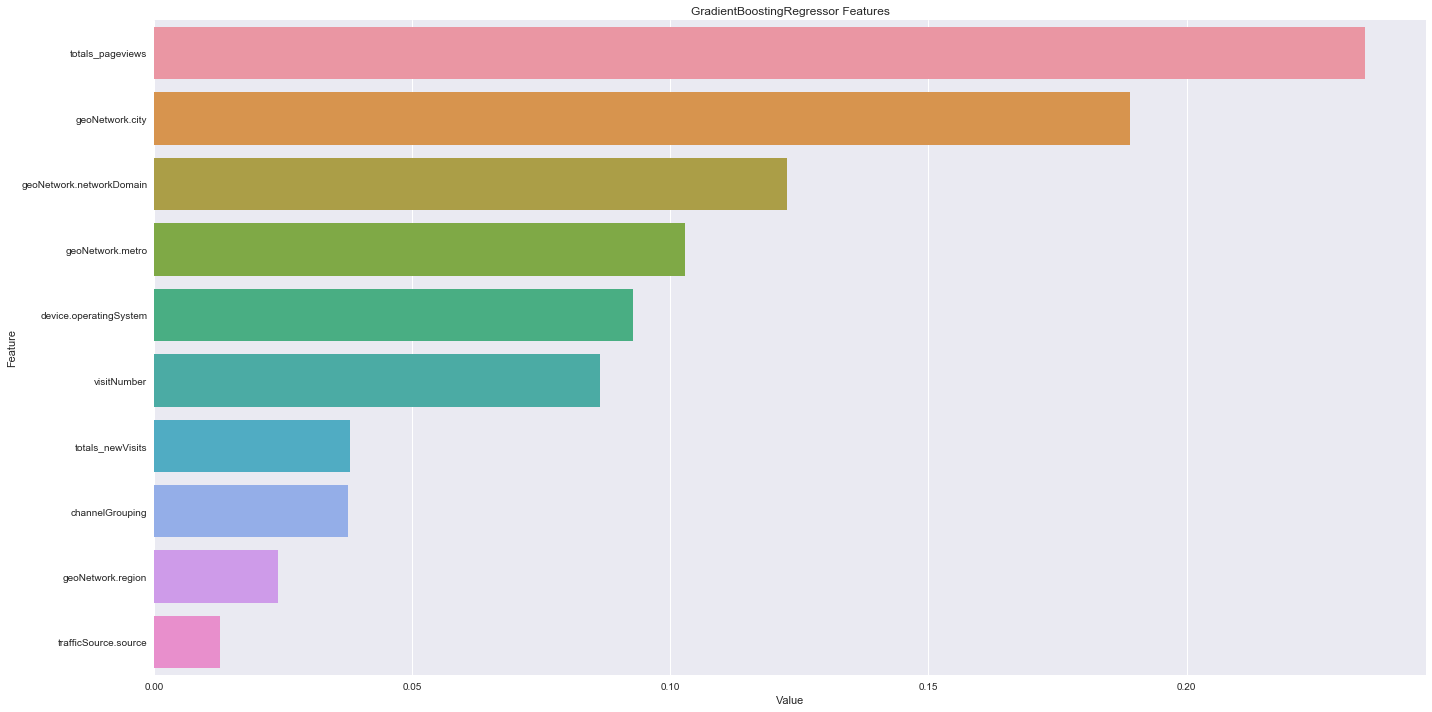

<Figure size 432x288 with 0 Axes>

In [197]:
feature_imp_gbrt = pd.DataFrame(sorted(zip(gbrt.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp_gbrt.sort_values(by="Value", ascending=False).head(10))
plt.title('GradientBoostingRegressor Features')
plt.tight_layout()
plt.show()
plt.savefig('gbrt_importances-01.png')

In [49]:
# Evaluation of gbrt
y_pred_gbrt=gbrt.predict(X_test_reg) 
rms_gbrt = np.sqrt(mean_squared_error(y_test_reg, y_pred_gbrt)) 
print("RMSE:{e}".format(e=rms_gbrt))
print("r2 Score:{}".format(r2_score(y_test_reg, y_pred_gbrt)))
print("explained variance score:{}".format(explained_variance_score(y_test_reg, y_pred_gbrt)))

RMSE:1.4778443886415582
r2 Score:-0.29143320880808754
explained variance score:-0.1121528803505456


###### Random Forest Regressor

In [406]:
#random forest
param_grid_rf = {
                   'n_estimators':[100,200,500],
     'max_depth': [5,10,15],
    
                  'max_features': [5,10,15,'sqrt','log2','auto'],
    'max_leaf_nodes': [10,20,50,100]
                 
                  }
              
print("Parameter grid:\n{}".format(param_grid_rf))

grid_search_rf = GridSearchCV(RandomForestRegressor(criterion= 'mse', max_depth= 5, max_features= 'sqrt', max_leaf_nodes= 5), param_grid_rf, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train_reg,y_train_reg)


Parameter grid:
{'n_estimators': [100, 200, 500], 'max_depth': [5, 10, 15], 'max_features': [5, 10, 15, 'sqrt', 'log2', 'auto'], 'max_leaf_nodes': [10, 20, 50, 100]}


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='sqrt', max_leaf_nodes=5,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500], 'max_depth': [5, 10, 15], 'max_features': [5, 10, 15, 'sqrt', 'log2', 'auto'], 'max_leaf_nodes': [10, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [408]:
grid_search_rf.best_params_, grid_search_rf.best_score_

({'max_depth': 5,
  'max_features': 'log2',
  'max_leaf_nodes': 10,
  'n_estimators': 200},
 -7.303373433898766)

In [423]:
#random forest
param_grid_rf2 = {'min_samples_leaf':[10,20,50], 'min_samples_split':[10,20,50]
                 
                  }
              
print("Parameter grid:\n{}".format(param_grid_rf))

grid_search_rf2 = GridSearchCV(RandomForestRegressor(criterion= 'mse', max_depth= 5, max_features= 'log2', max_leaf_nodes= 10,n_estimators=200), param_grid_rf2, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
grid_search_rf2.fit(X_train_reg,y_train_reg)


Parameter grid:
{'n_estimators': [100, 200, 500], 'max_depth': [5, 10, 15], 'max_features': [5, 10, 15, 'sqrt', 'log2', 'auto'], 'max_leaf_nodes': [10, 20, 50, 100]}


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='log2', max_leaf_nodes=10,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [10, 20, 50], 'min_samples_split': [10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [424]:
grid_search_rf2.best_params_, grid_search_rf2.best_score_

({'min_samples_leaf': 10, 'min_samples_split': 10}, -7.257203737460263)

###### Fit model with best parameters

In [51]:
rf = RandomForestRegressor(criterion= 'mse',  max_depth=5, n_estimators= 200,max_features= 'log2', max_leaf_nodes= 10,min_samples_leaf=10, min_samples_split=10,random_state=10) 
rf.fit(X_train_reg, y_train_reg)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='log2', max_leaf_nodes=10,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=10, verbose=0, warm_start=False)

In [426]:
rf.score(X_train_reg, y_train_reg) 

0.11148056921742189

In [427]:
rf.score(X_test_reg, y_test_reg)

-0.19184789381588874

In [428]:
print(rf.feature_importances_)

[0.05442935 0.10052768 0.         0.04320887 0.23544416 0.
 0.00095735 0.00030136 0.13924683 0.12647964 0.         0.
 0.07668092 0.13112333 0.0446295  0.         0.01197103 0.
 0.        ]


In [52]:
# Evaluation of rf

y_pred = rf.predict(X_test)
rms_rf = np.sqrt(mean_squared_error(y_test, y_pred)) 
print("RMSE:{e}".format(e=rms_rf))
print("r2 Score:{}".format(r2_score(y_test, y_pred)))
print("explained variance score:{}".format(explained_variance_score(y_test, y_pred)))

RMSE:17.140997536872526
r2 Score:-28960.61721637713
explained variance score:-3.931806865768385


In [432]:
# Evaluation of gbrt
y_pred_gbrt=gbrt.predict(X_test_reg) 
rms_gbrt = np.sqrt(mean_squared_error(y_test_reg, y_pred_gbrt))  
print("RMSE:{e}".format(e=rms_gbrt))
print("r2 Score:{}".format(r2_score(y_test_reg, y_pred_gbrt)))
print("explained variance score:{}".format(explained_variance_score(y_test_reg, y_pred_gbrt)))

RMSE:1.4778443886415582
r2 Score:-0.29143320880808754
explained variance score:-0.1121528803505456


###### Gradient Boosting Model has lesser RMSE value compared to Random Forest Model. Thus we prefer Gradient Boosting Model over Random Forest. 

## Aggrerate Results

In [53]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [54]:
y_pred_revenue=gbrt.predict(X) 

In [201]:
y_pred_revenue.shape

(193,)

In [55]:
data.loc[data['y_pred'] == 0, 'predicted_revenue'] = 0

In [56]:
data.loc[data['y_pred'] == 1, 'predicted_revenue'] = np.expm1(y_pred_revenue)

In [295]:
data.head()

,index,channelGrouping,visitNumber,totals_bounces,totals_newVisits,totals_pageviews,totals_transactionRevenue,totals_transactions,device.browser,device.deviceCategory,...,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,trafficSource.source,customDimensions.index,customDimensions.value,classify_revenue,y_pred,predicted_revenue
date,,,,,,,,,,,,,,,,,,,,,
2017-10-16,0,3,1.00,1.00,1.00,1.00,0.00,0.00,8,0,...,0,0,0,21,25,4,3,0,0,0.00
2017-10-16,1,5,6.00,0.00,0.00,2.00,0.00,0.00,5,0,...,27,0,18,12,70,4,4,0,0,0.00
2017-10-16,2,1,1.00,0.00,1.00,2.00,0.00,0.00,5,1,...,0,2435,0,12,0,4,4,0,0,0.00
2017-10-16,3,3,1.00,0.00,1.00,2.00,0.00,0.00,5,0,...,0,0,0,20,25,4,3,0,0,0.00
2017-10-16,4,3,1.00,0.00,1.00,2.00,0.00,0.00,5,0,...,0,1647,0,3,25,4,2,0,0,0.00


In [57]:
zero_revenue=data.loc[data['y_pred'] == 0]

In [58]:
non_zero_revenue=data.loc[data['y_pred'] == 1]

In [68]:
daily_non_zero_revenue=non_zero_revenue.reset_index().groupby(['date','fullVisitorId'])[['y_pred','totals_transactionRevenue','predicted_revenue']].sum()

In [69]:
daily_zero_revenue=zero_revenue.reset_index().groupby(['date','fullVisitorId'])[['y_pred','totals_transactionRevenue','predicted_revenue']].sum()

In [70]:
daily_revenue = [daily_zero_revenue, daily_non_zero_revenue]

result_revenue = pd.concat(daily_revenue)

###### Daily Revenue customer wise (Actual vs Predicted)

In [71]:
result_revenue

y_pred  totals_transactionRevenue  \
date       fullVisitorId                                            
2016-09-02 0000245437374675368       0                       0.00   
           0004803397127474847       0                       0.00   
           0005096736076850458       0                       0.00   
           0005694527603480368       0                       0.00   
           0006008740756625566       0                       0.00   
           0013232932172978597       0                       0.00   
           0013251180141982691       0                       0.00   
           0015065858137292339       0                       0.00   
           0018131669611141208       0                       0.00   
           00189307122537490         0                       0.00   
           0019595737093157672       0                       0.00   
           0023915926406891691       0                       0.00   
           0024614448930582896       0                       0.00   
           0025489527250127533       0                       0.00   
           0026203741366904270       0                       0.00   
           0032800017373881379       0                       0.00   
           0036373064505192879       0                       0.00   
           0042187268246961920       0                       0.00   
           0044837250765400461       0                       0.00   
           0047340919599668919       0                       0.00   
           0049101279449587870       0                       0.00   
           0057228682567989873       0                       0.00   
           0063191589012692475       0                       0.00   
           0064126531968275290       0                       0.00   
           0065831017977762658       0                       0.00   
           0071296090489144908       0                       0.00   
           007550135458178321        0                       0.00   
           0078588241654233667       0                       0.00   
           0087240106724750745       0                       0.00   
           010089030391699708        0                       0.00   
...                                ...                        ...   
2017-11-30 2875842843843422362       1               107960000.00   
           3287935319409551745       1                83180000.00   
           3371421134809281185       1                28930000.00   
           3517667571922875880       1               134750000.00   
           4261759267361269648       1                46430000.00   
           4954404706370546472       1                24980000.00   
           4962088874496440474       1                55990000.00   
           5693109963199016413       1               207490000.00   
           5774144420048753588       1                 8490000.00   
           5828412432443212029       1               241250000.00   
           6739930820441913668       1                13950000.00   
           8169242395174514673       1               199870000.00   
           849161684199944498        1                50380000.00   
           9340341966296957897       1               207950000.00   
           943945152769904281        1                83180000.00   
           9549089852095378957       1                85430000.00   
           9851027407827249742       1                44580000.00   
2018-04-15 0534135751322735189       1                30960000.00   
           0542979939655528437       1               119990000.00   
           099652446932071844        1                87960000.00   
           1599643548348828766       1                23960000.00   
           1626167154986051036       1                17590000.00   
           3102343581929921848       2                43980000.00   
           3648111227535332603       1                41980000.00   
           4843786684243145195       1                39980000.00   
           6923363827219009344

In [63]:
user_wise_zero_revenue=zero_revenue.reset_index().groupby('fullVisitorId')[['y_pred','totals_transactionRevenue','predicted_revenue']].sum()

In [64]:
user_wise_revenue=non_zero_revenue.reset_index().groupby('fullVisitorId')[['y_pred','totals_transactionRevenue','predicted_revenue']].sum()

In [65]:
frames = [user_wise_zero_revenue, user_wise_revenue]

result = pd.concat(frames)

###### Visitor wise revenue summary

In [73]:
result

,y_pred,totals_transactionRevenue,predicted_revenue
fullVisitorId,,,
0000245437374675368,0,0.00,0.00
0000593255797039768,0,0.00,0.00
0000750929315523353,0,0.00,0.00
0001191766179392657,0,0.00,0.00
0003631840334189025,0,0.00,0.00
0004374401845204055,0,0.00,0.00
0004803397127474847,0,0.00,0.00
0005096736076850458,0,0.00,0.00
0005694527603480368,0,0.00,0.00


###### Datewise actual vs predicted zero revenue

In [390]:
zero_revenue.reset_index().groupby('date')[['totals_transactionRevenue','predicted_revenue']].sum()

,totals_transactionRevenue,predicted_revenue
date,,
2016-09-02,0.00,0.00
2017-01-26,0.00,0.00
2017-02-03,0.00,0.00
2017-03-12,19990000.00,0.00
2017-06-23,0.00,0.00
2017-10-16,0.00,0.00
2017-11-10,227000000.00,0.00
2017-11-30,105540000.00,0.00
2018-04-15,0.00,0.00


###### Datewise Actual vs predicted revenue

In [303]:
non_zero_revenue.reset_index().groupby('date')[['totals_transactionRevenue','predicted_revenue']].sum()

,totals_transactionRevenue,predicted_revenue
date,,
2016-09-02,4322440000.00,1478682937.40
2017-01-26,3715200000.00,1439259792.41
2017-02-03,4583980000.00,1290921046.80
2017-03-12,556300000.00,497842049.86
2017-06-23,2040210000.00,1194161474.72
2017-10-16,1655420000.00,1108952146.57
2017-11-10,1414100000.00,687975323.54
2017-11-30,1767300000.00,880661826.65
2018-04-15,583900000.00,628048525.19


# Part 2
In this part you will create a Python function ``plot_decision_boundary`` that will accepts a machine learning model, feature set ``X``, and target set ``y`` as input and will plot the decision boundary of the input machine learning model  on ``(X,y)``. The following is a sample run of this function: 

```Python
%matplotlib inline
# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training a classifier
svm = SVC(C=0.5, kernel='linear')
svm.fit(X, y)

# Plotting decision boundary
plot_decision_boundary(X, y, clf=svm)

# Adding axes annotations
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.title('SVM on Iris')```

Sample output: 
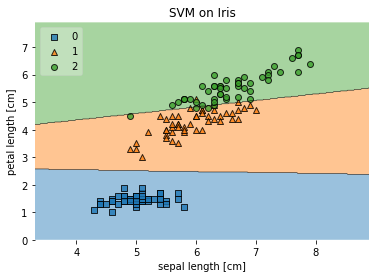

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import mglearn
import matplotlib.pyplot as plt
% matplotlib inline

In [76]:
import numpy as np
import pandas as pd

In [77]:
import matplotlib.colors as c

In [78]:
import warnings
warnings.filterwarnings("ignore")

In [79]:
from sklearn import datasets

In [94]:
def plot_decision_boundary(X,y,clf):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
    fig = plt.subplots(figsize=(12,6))
    markers = ('o', 'x', 'd')
    colors = ('purple', 'blue', 'green')
    cmap = c.ListedColormap(colors[:len(np.unique(y))])  
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4)
    for idx, lab in enumerate(np.unique(y)):
        plt.scatter(x=X[y == lab, 0], y=X[y == lab, 1], alpha=1.0, c=cmap(idx), marker=markers[idx], label=lab)
   
    plt.title("{}".format(clf.__class__.__name__))
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")
    plt.legend()
    pass

###### Logistic Regression

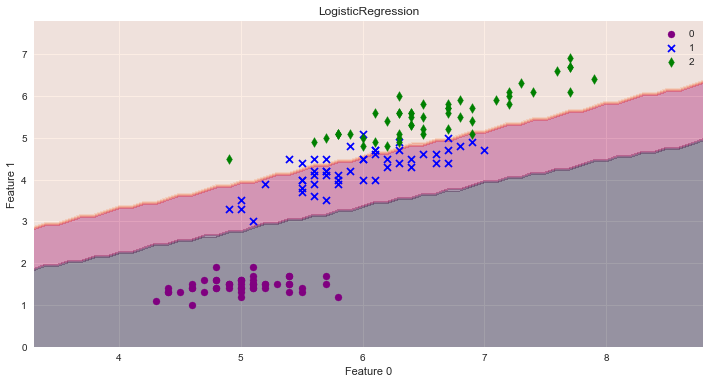

In [97]:
data=datasets.load_iris()
X = data.data[:, [0, 2]]
y = data.target
clf = LogisticRegression().fit(X, y)
plot_decision_boundary(X,y,clf)

###### SVM

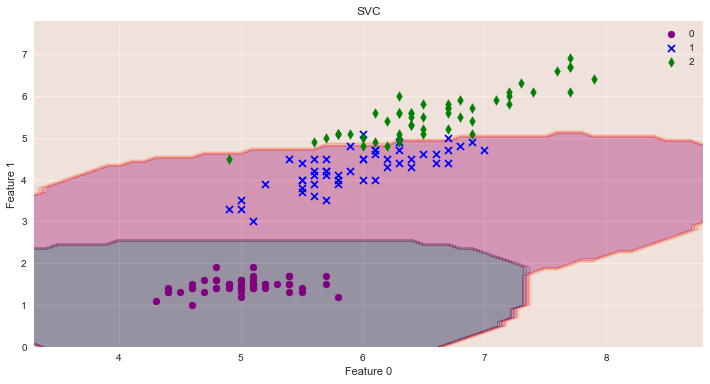

In [98]:
svm = SVC(C=0.5, kernel='rbf')
svm.fit(X, y)
plot_decision_boundary(X,y,svm)